In [1]:
ROOT_PATH = '../../../../'
# UKBB_DATA_PATH = ROOT_PATH + 'assets/data/ukbb/'
BASE_LOG_PATH = ROOT_PATH + 'medical_mesh_experiments/SVIExperiment'
# FIGURE_SAVE_PATH = 'figures'

In [2]:
import sys
import os

sys.path.append(ROOT_PATH)
os.environ['CUDA_VISIBLE_DEVICES'] = ''

from tqdm import tqdm, trange

import traceback
import warnings
from scipy.stats import gaussian_kde

warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
%matplotlib inline
import inspect
from collections import OrderedDict
from itertools import product
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import torch
import seaborn as sns

torch.autograd.set_grad_enabled(False);

import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')

import pyvista as pv
pv.set_plot_theme("document")

# from coma.utils.visualise import plot_mesh_pyvista, plot_meshes_pyvista

In [4]:
# from coma.datasets.ukbb_meshdata import UKBBMeshDataset, VerticesDataLoader
# from coma.utils import transforms

# # # Preprocessor
# preprocessor = transforms.get_transforms()

# brain_substructure = 'R_Hipp'

# # # Load Dataset
# mesh_path = "/vol/biomedic3/bglocker/brainshapes"
# cache_path = "/vol/bitbucket/rrr2417/deepscm_data_cache"
# csv_path = "/vol/biomedic3/bglocker/brainshapes/ukb21079_extracted.csv"
# split = 0.8

# substructure_to_udi = {
#     'BrStem': '25025-2.0', 
#     'L_Thal': '25011-2.0',
#     'L_Caud': '25013-2.0',
#     'L_Puta': '25015-2.0',
#     'L_Pall': '25017-2.0',
#     'L_Hipp': '25019-2.0',
#     'L_Amyg': '25021-2.0',
#     'L_Accu': '25023-2.0',
#     'R_Thal': '25012-2.0',
#     'R_Caud': '25014-2.0',
#     'R_Puta': '25016-2.0',
#     'R_Pall': '25018-2.0',
#     'R_Hipp': '25020-2.0',
#     'R_Amyg': '25022-2.0',
#     'R_Accu': '25024-2.0',
# }

# feature_name_map = {
#     '31-0.0': 'sex',
#     '21003-0.0': 'age',
#     substructure_to_udi[brain_substructure]: 'structure_volume',  # Brain Stem
#     '25010-2.0': 'brain_volume',  # Unnormalised brain volume from UKBB
# }

# metadata_df = pd.read_csv(csv_path)

# total_train_dataset = UKBBMeshDataset(
#     mesh_path,
#     substructures=[brain_substructure],
#     split=split,
#     train=True,
#     transform=preprocessor,
#     reload_path=True,
#     features_df=metadata_df,
#     feature_name_map=feature_name_map,
#     cache_path=cache_path,
# )

# val_split = 0.1
# total_train_length = len(total_train_dataset)
# val_length = int(val_split * total_train_length)
# train_length = total_train_length - val_length

# train_dataset, val_dataset = torch.utils.data.random_split(
#     total_train_dataset,
#     lengths=[train_length, val_length],
#     generator=torch.Generator().manual_seed(42),
# )

# data = [train_dataset[i] for i in range(len(train_dataset))]
# meshes = torch.cat([mesh for (mesh, _) in data], 0).detach().numpy()
# print(meshes.shape)
# metadata_df = pd.concat([df for (_, df) in data], 0)
# print(metadata_df.shape)
# metadata_df.head()
# torch.save(meshes, 'training_hipp_meshes.pt')
# metadata_df.to_csv('training_hipp_metadata.csv')

# metadata_df = pd.read_csv(csv_path)
# total_test_dataset = UKBBMeshDataset(
#     mesh_path,
#     substructures=[brain_substructure],
#     split=split,
#     train=False,
#     transform=preprocessor,
#     reload_path=True,
#     features_df=metadata_df,
#     feature_name_map=feature_name_map,
#     cache_path=cache_path,
# )
# data = [total_test_dataset[i] for i in range(len(total_test_dataset))]
# meshes = torch.cat([mesh for (mesh, _) in data], 0).detach().numpy()
# print(meshes.shape)
# metadata_df = pd.concat([df for (_, df) in data], 0)
# print(metadata_df.shape)
# metadata_df.head()
# torch.save(meshes, 'testing_hipp_meshes.pt')
# metadata_df.to_csv('testing_hipp_metadata.csv')

In [5]:
# test_stem_meshes = torch.load('testing_meshes.pt')
# test_stem_metadata_df = pd.read_csv('testing_metadata.csv')
# print(test_stem_metadata_df.head())

# train_stem_metadata_df = pd.read_csv('training_metadata.csv')
# train_stem_meshes = torch.load('training_meshes.pt')
# print(train_stem_metadata_df.head())

In [6]:
test_hipp_meshes = torch.load('testing_hipp_meshes.pt')
test_hipp_metadata_df = pd.read_csv('testing_hipp_metadata.csv')
print(test_hipp_metadata_df.head())

# train_hipp_metadata_df = pd.read_csv('training_hipp_metadata.csv')
# train_hipp_meshes = torch.load('training_hipp_meshes.pt')
# print(train_hipp_metadata_df.head())

   Unnamed: 0      eid  sex  age  structure_volume  brain_volume
0        4804  5026976    0   58              3856       1073400
1        3178  5027256    1   60              4478       1282190
2        4669  5027577    0   65              3805       1097400
3         845  5027876    0   56              3900       1093200
4        4457  5028604    1   62              3911       1191110


In [7]:
test_hipp_meshes.shape

(2901, 664, 3)

In [8]:
template_path = '/vol/biomedic3/bglocker/brainshapes/5026976'
stem_name = 'T1_first-BrStem_first.vtk'
hipp_name = 'T1_first-R_Hipp_first.vtk'
stem_template = pv.read(f'{template_path}/{stem_name}')
hipp_template = pv.read(f'{template_path}/{hipp_name}')

In [9]:
hipp_template.n_points

664

## Load Model 

In [8]:
# from deepscm.experiments.medical_meshes import ukbb  # noqa: F401
# from deepscm.experiments.medical_meshes.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY

In [10]:
# def load_model(base_log_path, exp='ConditionalVISEM', version='version_87'):
#     checkpoint_path = f'{base_log_path}/{exp}/{version}/'
#     base_path = os.path.join(checkpoint_path, 'checkpoints')
#     checkpoint_path = os.path.join(base_path, os.listdir(base_path)[0])

#     ckpt = torch.load(checkpoint_path, map_location=torch.device('cpu'))
#     hparams = ckpt['hyper_parameters']

#     model_class = MODEL_REGISTRY[hparams['model']]

#     model_params = {
#         k: v for k, v in hparams.items() if (
#             k in inspect.signature(model_class.__init__).parameters
#             or k in k in inspect.signature(model_class.__bases__[0].__init__).parameters
#             or k in k in inspect.signature(model_class.__bases__[0].__bases__[0].__init__).parameters
#         )
#     }
#     model_params['gpu'] = 0

#     new_state_dict = OrderedDict()

#     for key, value in ckpt['state_dict'].items():
#         new_key = key.replace('pyro_model.', '')
#         new_state_dict[new_key] = value

#     loaded_model = model_class(**model_params)
#     loaded_model.load_state_dict(new_state_dict)

#     for p in loaded_model._buffers.keys():
#         if 'norm' in p:
#             setattr(loaded_model, p, getattr(loaded_model, p))

#     loaded_model.eval()
#     # loaded_models[exp] = loaded_model

#     def sample_pgm(num_samples, model):
#         with pyro.plate('observations', num_samples):
#             return model.pgm_model()

#     model = partial(sample_pgm, model=loaded_model)
    
#     return loaded_model, model

In [11]:
# hipp_loaded_model, hipp_model = load_model(
#     BASE_LOG_PATH, 'ConditionalVISEM', 'version_118'
# )

## Counterfactuals

In [12]:
var_name = {
    'structure_volume': 'v',
    'brain_volume': 'b',
    'sex': 's',
    'age': 'a',
}
value_fmt = {
    'structure_volume': lambda s: f'{np.round(float(s)/1000, 4)}ml',
    'brain_volume': lambda s: f'{np.round(float(s)/1000, 4)}ml',  # rf'{float(s)/1000:.4g}\,\mathrm{{ml}}',
    'age': lambda s: f'{int(s)}y',   # rf'{int(s):d}\,\mathrm{{y}}',
    'sex': lambda s: '{}'.format(['female', 'male'][int(s)])
}

def fmt_intervention(intervention):
    if isinstance(intervention, str):
        var, value = intervention[3:-1].split('=')
        return f"$do({var_name[var]}={value_fmt[var](value)})$"
    else:
        intervention_strs = [
            f'{var_name[k]}={value_fmt[k](v)}'
            for k, v in intervention.items()
        ]
        all_interventions = ', '.join(intervention_strs)
        return f"do({all_interventions})"

def prep_data(input_dict):
    x = torch.tensor(input_dict['x']).unsqueeze(0).float()
    age = torch.tensor([[input_dict['age']]]).float()
    sex = torch.tensor([[input_dict['sex']]]).float()
    structure_volume = torch.tensor([[input_dict['structure_volume']]]).float()
    brain_volume = torch.tensor([[input_dict['brain_volume']]]).float()

    return {
        'x': x,
        'age': age,
        'sex': sex,
        'structure_volume': structure_volume,
        'brain_volume': brain_volume
    }

def get_inputs_for_counterfactuals(metadata_df, meshes, age_sex_samples):
    all_inputs = []
    eids = []
    
    for age, sex in age_sex_samples:
        mask = (metadata_df.age == age) & (metadata_df.sex == sex)

        row = metadata_df[mask].head(1)
        eid = row.eid.values[0]
        brain_volume = row.brain_volume.values[0]
        structure_volume = row.structure_volume.values[0]
        x = meshes[mask][0]
        # print(x)

        input_dict = {
            'x': x,
            'age': age,
            'sex': sex,
            'brain_volume': brain_volume,
            'structure_volume': structure_volume
        }
        all_inputs.append(input_dict)
        eids.append(eid)
        
    return all_inputs, eids

def get_counterfactuals(age_sex_samples, all_inputs, all_interventions, model, num_samples=1):
    counterfactuals = {}

    for (age, sex), orig_data, interventions in zip(age_sex_samples, all_inputs, all_interventions):
        imgs, diffs = [], []
        orig_data = prep_data(orig_data)

        for intervention in interventions:
            pyro.clear_param_store()

            cond = {k: torch.tensor([[v]]) for k, v in intervention.items()}
            counterfactual = model.counterfactual(
                orig_data, cond, num_samples
            )

            imgs += [counterfactual['x']]
            diffs += [(- orig_data['x'] + counterfactual['x']).squeeze().mean(axis=1)]

        counterfactuals[(age, sex)] = {'imgs': imgs, 'diffs': diffs}
    
    return counterfactuals

def plot_counterfactuals(age_sex_samples, eids, all_inputs, all_interventions, template, counterfactuals, clim):
    width = 768 * 2
    height = int(width / (1.618 * 2))

    rotations = [(0, 0, 240)]

    for age_sex, eid, orig_data, interventions in zip(age_sex_samples, eids, all_inputs, all_interventions):
        counterfactual = counterfactuals[age_sex]

        polydatas = [template]
        for img in counterfactual['imgs']:
            template_copy = template.copy()
            template_copy.points = img.squeeze(0).numpy()
            polydatas.append(template_copy)
        
        colors = np.concatenate(
            [np.zeros((1, template_copy.points.shape[0]))] +
            [np.expand_dims(diff, 0) for diff in counterfactual['diffs']]
        )
        age_title = f'{var_name["age"]}={value_fmt["age"](str(age_sex[0]))}' 
        sex_title = f'{var_name["sex"]}={value_fmt["sex"](str(age_sex[1]))}'
        titles = [f'{age_title}, {sex_title}']
        titles += [fmt_intervention(_intervention) for _intervention in interventions]

        plotter = pv.Plotter(
            shape=(1, len(polydatas)),
            window_size=(width, height),
            border=False,
            lighting='light_kit',
            off_screen=True,
            notebook=True,
        )

        plot_meshes_pyvista(
            plotter,
            polydatas,
            rotations=rotations * len(polydatas),
            vertexcolors=colors,
            vertexscalar='distance',
            scalar_bar_idx=len(polydatas) - 1,
            titles=titles,
            mesh_kwargs=dict(
                smooth_shading=True,
                cmap='seismic',
                clim=clim,
            ),
            scalar_bar_kwargs=dict(
                label_font_size=10,
                position_x=0.85,
                title_font_size=10,
                shadow=True,
                n_labels=2,
                fmt='%.2fmm',
            ),
            title_kwargs=dict(
                font_size=8,
            ),
        )
        plotter.show()  # screenshot='spectral_modes_brain_stem.png')

In [74]:
age_sex_samples = [
    (40, 1), (45, 1), (50, 1), (55, 1), (60, 1), (65, 1), (70, 1),
    (40, 0), (45, 0), (50, 0), (55, 0), (60, 0), (65, 0), (70, 0),
]
all_age_interventions = [[
    {'age': 35.},
#     {'age': 40.},
    {'age': 45.},
#     {'age': 50.},
    {'age': 55.},
#     {'age': 60.},
    {'age': 65.},
#     {'age': 70.},
    {'age': 75.},
#     {'age': 80.},
]] * len(age_sex_samples)
all_sex_interventions = [[{'sex': 0.}, {'sex': 1.}]] * len(age_sex_samples)

In [14]:
cfs = {
    'stem': {'training': {'age': None, 'sex': None}, 'testing': {'age': None, 'sex': None}},
    'hipp': {'training': {'age': None, 'sex': None}, 'testing': {'age': None, 'sex': None}},
}

### Hippocampus

In [15]:
# model_nos = [118, 120]  # , 116, 117]
# models = {
#     no: load_model(BASE_LOG_PATH, 'ConditionalVISEM', f'version_{no}')[0]
#     for no in model_nos
# }

# cfs = {}

# for no, model in models.items():
#     all_inputs, eids = get_inputs_for_counterfactuals(
#         test_hipp_metadata_df, test_hipp_meshes, age_sex_samples
#     )
#     counterfactuals = get_counterfactuals(
#         age_sex_samples, all_inputs, all_age_interventions, model,
#     )
#     cfs[no] = counterfactuals
    
# np.save('cfs_all_brain_hipp_2_sex', cfs)

In [79]:
# cfs_dict = np.load('cf_dict_v87_90.npy', allow_pickle=True)[()]
all_age_interventions_list = [_int['age'] for _int in all_age_interventions[0]]
all_sex_interventions_list = [_int['sex'] for _int in all_sex_interventions[0]]
# stem_means_by_age = get_means_dict(
#     train_stem_meshes,
#     train_stem_metadata_df.age,
#     all_age_interventions_list
# )
# stem_means_by_sex = get_means_dict(
#     train_stem_meshes,
#     train_stem_metadata_df.sex,
#     all_sex_interventions_list
# )

In [17]:
cfs = np.load('cfs_all_brain_hipp_2_sex.npy', allow_pickle=True)[()]
cfs.keys()

dict_keys([118, 120])

In [40]:
def plot_age_counterfactuals_with_means(
    plotter, _cfs_dict, _template, _metadata_df, _meshes, _age, _sex,
    all_age_interventions_list, _clim=[-2., 2.], _cmap='seismic',
    _scalar='diff', rot=(0, 0, 200),
):
    age_title = f'{var_name["age"]}={value_fmt["age"](str(_age))}' 
    sex_title = f'{var_name["sex"]}={value_fmt["sex"](str(_sex))}'
    title = f'Ground Truth \n{age_title}, {sex_title}'

    def template_with_points(template, points):
        _template = template.copy()
        _template.points = points
        return _template

    def rot_template(template, rot):
        template.rotate_x(rot[0])
        template.rotate_y(rot[1])
        template.rotate_z(rot[2])

    def plot_mesh(x, y, title, mesh_arr, diff, template):
        plotter.subplot(x, y)
        plotter.add_title(title, font_size=8)
        mesh = template_with_points(template, mesh_arr)
        rot_template(mesh, rot)
        mesh[_scalar] = diff
        plotter.add_mesh(
            mesh,
            scalars=_scalar,
            cmap=_cmap,
            clim=_clim,
            smooth_shading=True,
            flip_scalars=True,
            show_scalar_bar=False
        )

    ground_truth_mesh = get_inputs_for_counterfactuals(_metadata_df, _meshes, [age_sex_pair])[0][0]['x']
    ground_truth = template_with_points(_template, ground_truth_mesh)
    rot_template(ground_truth, rot)
    ground_truth[_scalar] = np.zeros(_template.points.shape[0])

    mask = (_metadata_df.age == _age) & (_metadata_df.sex == _sex)
    _mean_mesh = _meshes[mask].mean(axis=0)

    plotter.subplot(1, 0)
    actor = plotter.add_title(title, font_size=8)
    plotter.add_mesh(ground_truth, scalars=_scalar, cmap=_cmap, clim=_clim, smooth_shading=True, flip_scalars=True, show_scalar_bar=False)

    for i, _age in enumerate(all_age_interventions_list):
        cf_mesh = _cfs_dict['imgs'][i].numpy()[0]
        diff = _cfs_dict['diffs'][i]
        plot_mesh(1, i + 1, f'do(a={int(_age)}y)', cf_mesh, diff, _template)

        mask = (_metadata_df.age == _age) & (_metadata_df.sex == _sex)

        if mask.sum():
            mean_mesh = _meshes[mask].mean(axis=0)
            diff = (-_mean_mesh + mean_mesh).mean(axis=1)
            plot_mesh(0, i + 1, f'Mean(a={int(_age)}y, {sex_title})', mean_mesh, diff, _template)
            diff = (-cf_mesh + mean_mesh).mean(axis=1)
            plot_mesh(2, i + 1, f'Mean(a={int(_age)}y, {sex_title}) - \n do(a={int(_age)}y)', cf_mesh, diff, _template)

    plotter.subplot(2, len(all_age_interventions_list))
    plotter.add_scalar_bar(
        label_font_size=15,
        position_x=0.5,
        position_y=0.35,
        title_font_size=20,
        shadow=True,
        n_labels=2,
        fmt='%.2fmm',
        vertical=True,
        fill=True,
    )

    plotter.show()

In [41]:
# cfs[model_idx][age_sex_pair]['x']

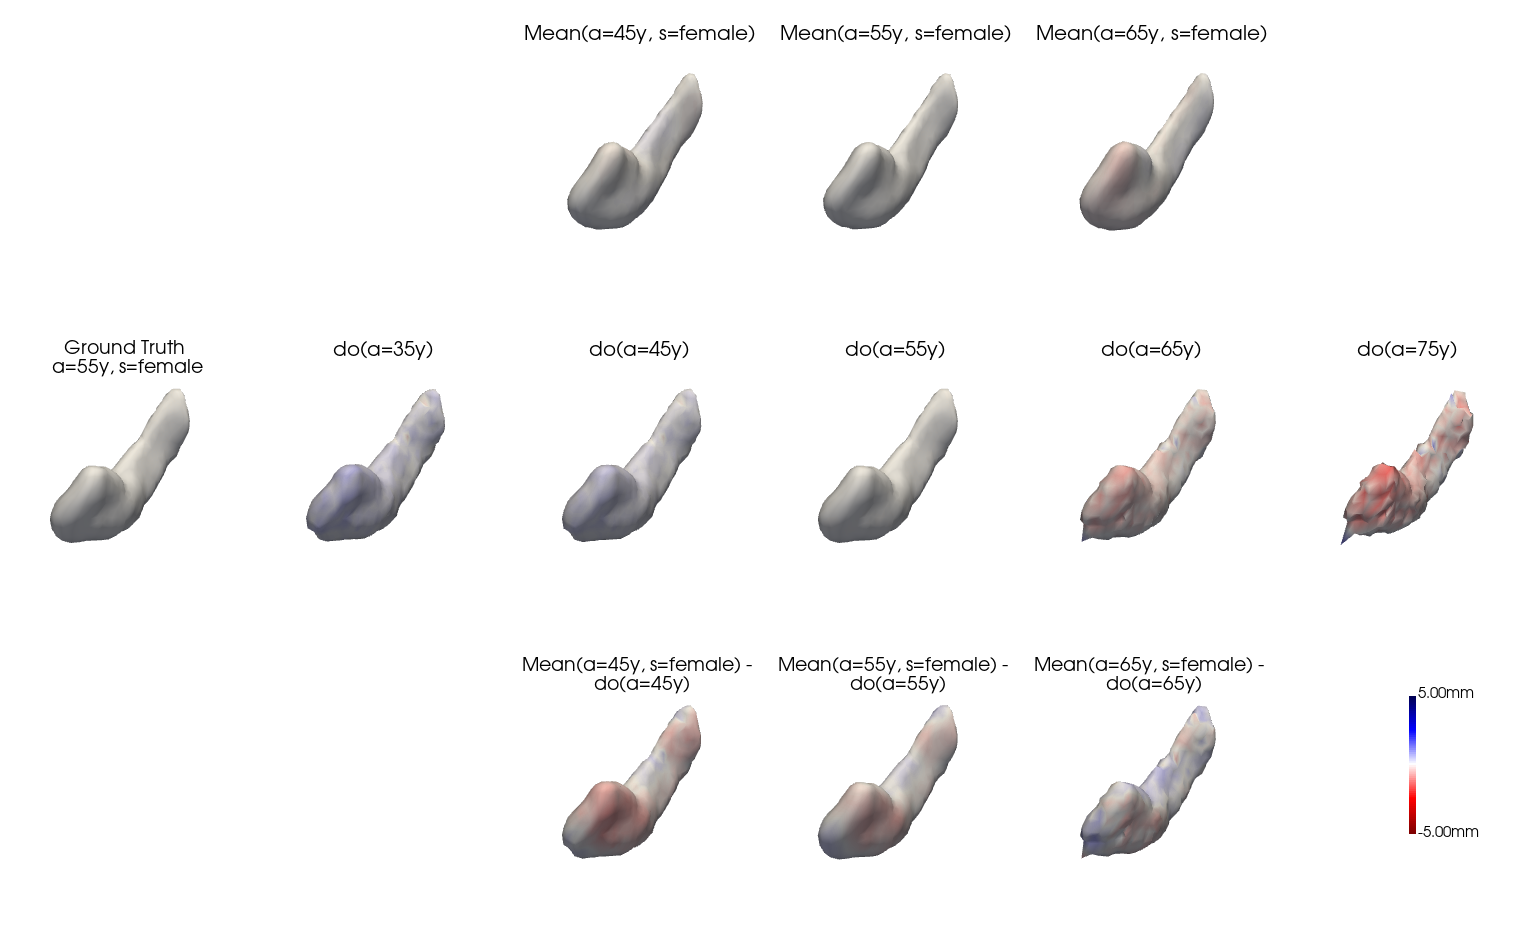

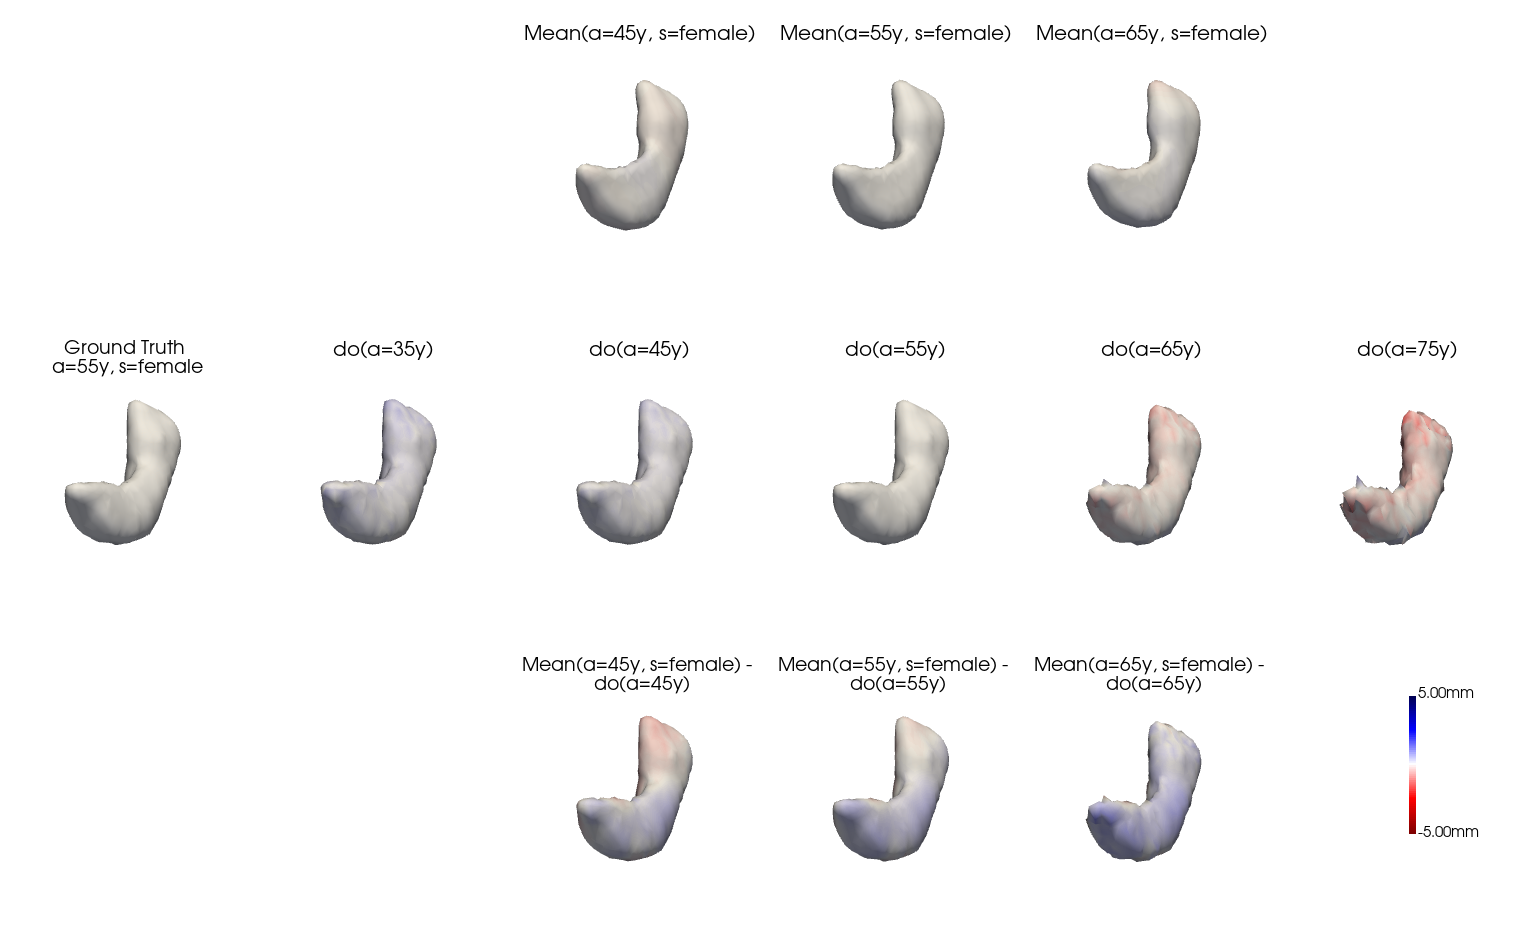

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [63]:
age_sex_pair = (55, 0)
sex = age_sex_pair[1]
age = age_sex_pair[0]

sex_letter = 'm' if sex else 'f'
model_idx = 118

width = 768 * 2
height = int(width / 1.618)

plotter = pv.Plotter(
    shape=(3, len(all_age_interventions_list) + 1),
    window_size=(width, height),
    border=False,
    lighting='light_kit',
    off_screen=True,
    notebook=True,
)

plot_age_counterfactuals_with_means(
    plotter,
    cfs[model_idx][age_sex_pair],
    hipp_template,
    test_hipp_metadata_df,
    test_hipp_meshes,
    age,
    sex,
    all_age_interventions_list,
    rot=(20, -80, 280),
    _clim=[-5., 5.],
)

plotter.screenshot(filename=f'HIPP_counterfactual_individual_traits_{age}y_{sex_letter}_front_latent_{model_idx}')

plotter = pv.Plotter(
    shape=(3, len(all_age_interventions_list) + 1),
    window_size=(width, height),
    border=False,
    lighting='light_kit',
    off_screen=True,
    notebook=True,
)

plot_age_counterfactuals_with_means(
    plotter,
    cfs[model_idx][age_sex_pair],
    hipp_template,
    test_hipp_metadata_df,
    test_hipp_meshes,
    age,
    sex,
    all_age_interventions_list,
    rot=(210, -80, 280),
    _clim=[-5, 5],
)

plotter.screenshot(filename=f'HIPP_counterfactual_individual_traits_{age}y_{sex_letter}_back_latent_{model_idx}')

In [45]:
def plot_sex_counterfactuals_with_means(
    plotter, _cfs_dict, _template, _metadata_df, _meshes, _age, _sex,
    all_sex_interventions_list, _clim=[-2., 2.], _cmap='seismic',
    _scalar='diff', rot=(0, 0, 200),
):
    age_title = f'{var_name["age"]}={value_fmt["age"](str(_age))}' 
    sex_title = f'{var_name["sex"]}={value_fmt["sex"](str(_sex))}'
    title = f'Ground Truth \n{age_title}, {sex_title}'

    def template_with_points(template, points):
        _template = template.copy()
        _template.points = points
        return _template

    def rot_template(template, rot):
        template.rotate_x(rot[0])
        template.rotate_y(rot[1])
        template.rotate_z(rot[2])

    def plot_mesh(x, y, title, mesh_arr, diff, template):
        plotter.subplot(x, y)
        plotter.add_title(title, font_size=8)
        mesh = template_with_points(template, mesh_arr)
        rot_template(mesh, rot)
        mesh[_scalar] = diff
        plotter.add_mesh(
            mesh,
            scalars=_scalar,
            cmap=_cmap,
            clim=_clim,
            smooth_shading=True,
            flip_scalars=True,
            show_scalar_bar=False
        )

    ground_truth_mesh = get_inputs_for_counterfactuals(_metadata_df, _meshes, [age_sex_pair])[0][0]['x']
    ground_truth = template_with_points(_template, ground_truth_mesh)
    rot_template(ground_truth, rot)
    ground_truth[_scalar] = np.zeros(_template.points.shape[0])

    mask = (_metadata_df.age == _age) & (_metadata_df.sex == _sex)
    _mean_mesh = _meshes[mask].mean(axis=0)

    plotter.subplot(1, 0)
    actor = plotter.add_title(title, font_size=8)
    plotter.add_mesh(ground_truth, scalars=_scalar, cmap=_cmap, clim=_clim, smooth_shading=True, flip_scalars=True, show_scalar_bar=False)

    for i, _sex in enumerate(all_sex_interventions_list):
        cf_mesh = _cfs_dict['imgs'][i].numpy()[0]
        diff = _cfs_dict['diffs'][i]
        _sex_title = f'{var_name["sex"]}={value_fmt["sex"](int(_sex))}'
        plot_mesh(1, i + 1, f'do({_sex_title})', cf_mesh, diff, _template)

        mask = (_metadata_df.age == _age) & (_metadata_df.sex == _sex)

        if mask.sum():
            mean_mesh = _meshes[mask].mean(axis=0)
            diff = (-_mean_mesh + mean_mesh).mean(axis=1)
            plot_mesh(0, i + 1, f'Mean({_sex_title}, {age_title})', mean_mesh, diff, _template)
            diff = (-cf_mesh + mean_mesh).mean(axis=1)
            plot_mesh(2, i + 1, f'Mean({_sex_title}, {age_title}) - \n do({_sex_title})', cf_mesh, diff, _template)

    plotter.subplot(2, 0)
    plotter.add_scalar_bar(
        label_font_size=15,
        position_x=0.5,
        position_y=0.35,
        title_font_size=20,
        shadow=True,
        n_labels=2,
        fmt='%.2fmm',
        vertical=True,
        fill=True,
    )

    plotter.show()

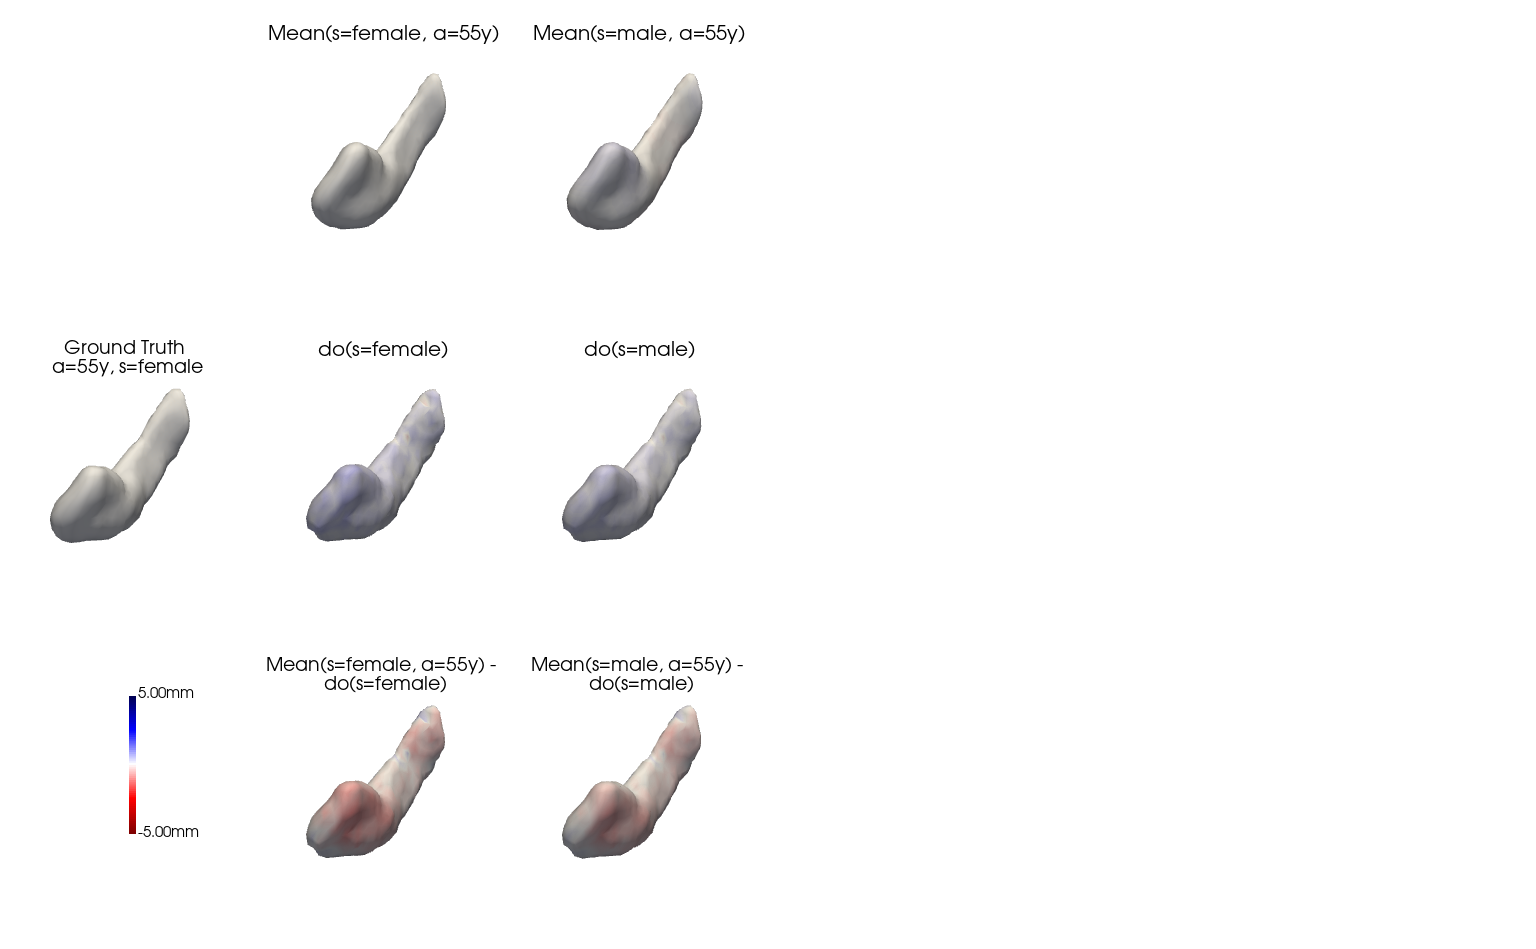

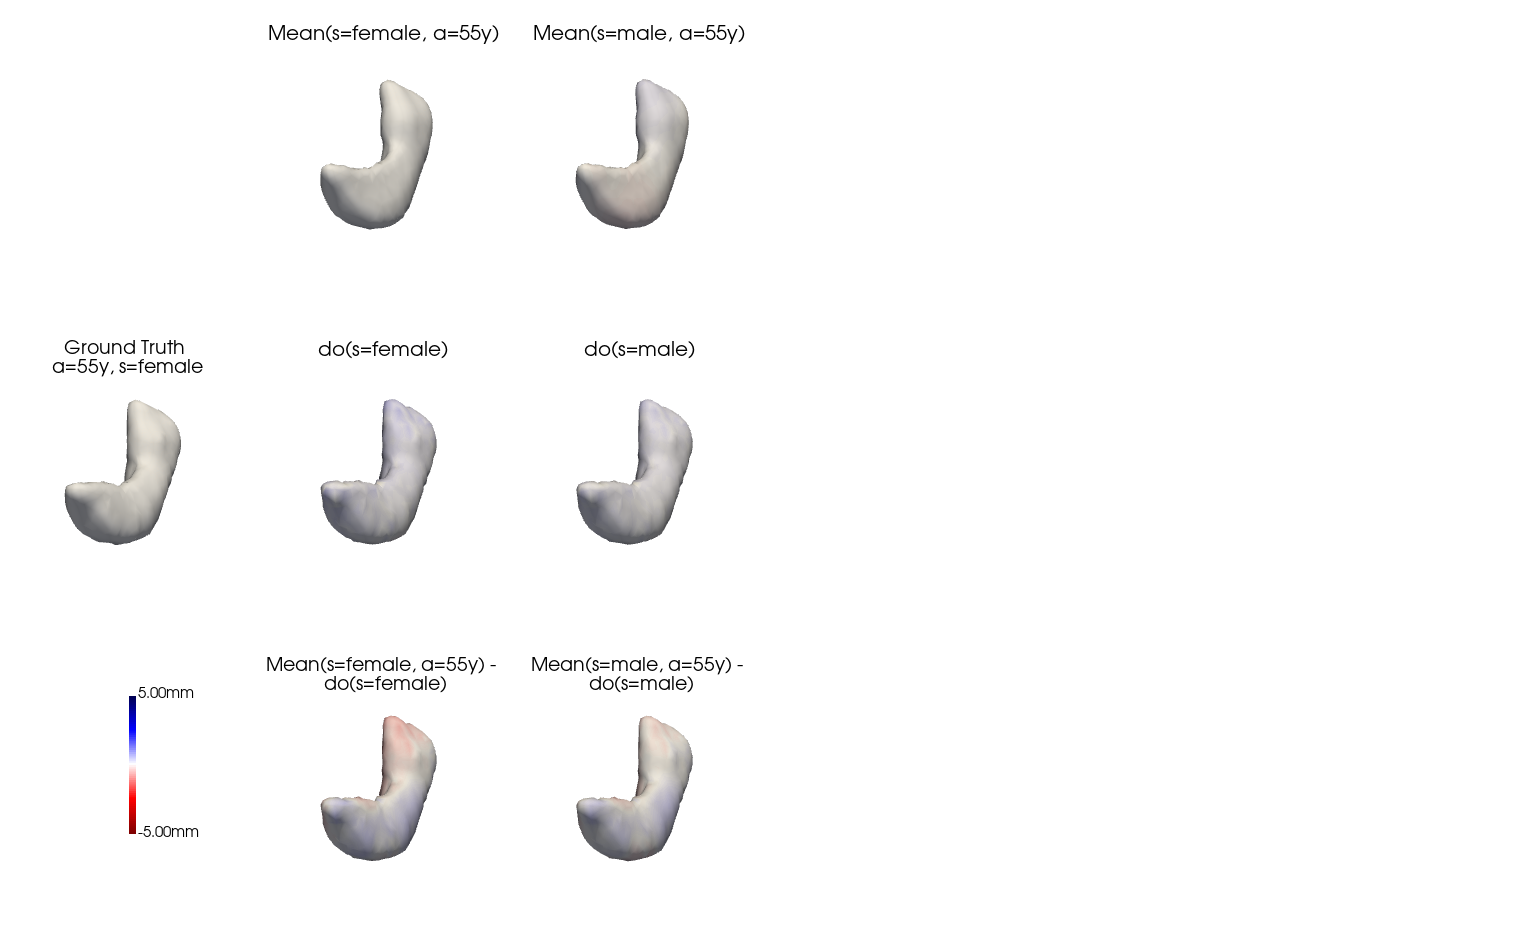

In [67]:
from PIL import Image

age_sex_pair = (55, 0)
sex = age_sex_pair[1]
age = age_sex_pair[0]

sex_letter = 'm' if sex else 'f'
model_idx = 118

width = 768 * 2
height = int(width / 1.618)

plotter = pv.Plotter(
    shape=(3, len(all_age_interventions_list) + 1),
    window_size=(width, height),
    border=False,
    lighting='light_kit',
    off_screen=True,
    notebook=True,
)

plot_sex_counterfactuals_with_means(
    plotter,
    cfs[model_idx][age_sex_pair],
    hipp_template,
    test_hipp_metadata_df,
    test_hipp_meshes,
    age,
    sex,
    all_sex_interventions_list,
    rot=(20, -80, 280),
    _clim=[-5, 5],
)

# print(f'counterfactual_individual_traits_{age}y_{sex_letter}_front_latent_{model_idx}')
filename = f'./HIPP_counterfactual_sex_individual_traits_{age}y_{sex_letter}_front_latent_{model_idx}.png'
plotter.screenshot(filename=filename)
im = Image.open(filename)
width, height = im.size
im1 = im.crop((0, 0, width / 2, height))
im1.save(filename, 'PNG', dpi=(300, 300))

plotter = pv.Plotter(
    shape=(3, len(all_age_interventions_list) + 1),
    window_size=(width, height),
    border=False,
    lighting='light_kit',
    off_screen=True,
    notebook=True,
)

plot_sex_counterfactuals_with_means(
    plotter,
    cfs[model_idx][age_sex_pair],
    hipp_template,
    test_hipp_metadata_df,
    test_hipp_meshes,
    age,
    sex,
    all_sex_interventions_list,
    rot=(210, -80, 280),
    _clim=[-5, 5],
)

filename = f'./HIPP_counterfactual_sex_individual_traits_{age}y_{sex_letter}_back_latent_{model_idx}.png'
plotter.screenshot(filename=filename)
im = Image.open(filename)
width, height = im.size
im1 = im.crop((0, 0, width / 2, height))
im1.save(filename, 'PNG', dpi=(300, 300))

In [70]:
def plot_all_age_counterfactuals(
    plotter, row_no, _cfs_dict, _template, _metadata_df, _meshes, 
    _age, _sex, all_age_interventions_list, _clim=[-2., 2.],
    _cmap='seismic', _scalar='diff', rot=(0, 0, 200),
):
    age_title = f'{var_name["age"]}={value_fmt["age"](str(_age))}' 
    sex_title = f'{var_name["sex"]}={value_fmt["sex"](str(_sex))}'
    title = f'Ground Truth \n{age_title}, {sex_title}'

    def template_with_points(template, points):
        _template = template.copy()
        _template.points = points
        return _template

    def rot_template(template, rot):
        template.rotate_x(rot[0])
        template.rotate_y(rot[1])
        template.rotate_z(rot[2])

    def plot_mesh(x, y, mesh_arr, diff, template):
        plotter.subplot(x, y)
        mesh = template_with_points(template, mesh_arr)
        rot_template(mesh, rot)
        mesh[_scalar] = diff
        plotter.add_mesh(
            mesh,
            scalars=_scalar,
            cmap=_cmap,
            clim=_clim,
            smooth_shading=True,
            flip_scalars=True,
            show_scalar_bar=False
        )

    ground_truth_mesh = get_inputs_for_counterfactuals(_metadata_df, _meshes, [(_age, _sex)])[0][0]['x']
    ground_truth = template_with_points(_template, ground_truth_mesh)
    rot_template(ground_truth, rot)
    ground_truth[_scalar] = np.zeros(_template.points.shape[0])
    
    plotter.subplot(row_no, 0)
    actor = plotter.add_title(title, font_size=8)
    plotter.add_mesh(ground_truth, scalars=_scalar, cmap=_cmap, clim=_clim, smooth_shading=True, flip_scalars=True, show_scalar_bar=False)

    for i, _age in enumerate(all_age_interventions_list):
        cf_mesh = _cfs_dict['imgs'][i].numpy()[0]
        diff = _cfs_dict['diffs'][i]
        plot_mesh(row_no, i + 1, cf_mesh, diff, _template)

In [ ]:
# def plot_all_age_counterfactuals(
#     plotter, _cfs_dict, _template, _metadata_df, _meshes, _age, _sex,
#     all_age_interventions_list, _clim=[-2., 2.], _cmap='seismic',
#     _scalar='diff', rot=(0, 0, 200),
# ):
#     age_title = f'{var_name["age"]}={value_fmt["age"](str(_age))}' 
#     sex_title = f'{var_name["sex"]}={value_fmt["sex"](str(_sex))}'
#     title = f'Ground Truth \n{age_title}, {sex_title}'

#     def template_with_points(template, points):
#         _template = template.copy()
#         _template.points = points
#         return _template

#     def rot_template(template, rot):
#         template.rotate_x(rot[0])
#         template.rotate_y(rot[1])
#         template.rotate_z(rot[2])

#     def plot_mesh(x, y, title, mesh_arr, diff, template):
#         plotter.subplot(x, y)
#         plotter.add_title(title, font_size=8)
#         mesh = template_with_points(template, mesh_arr)
#         rot_template(mesh, rot)
#         mesh[_scalar] = diff
#         plotter.add_mesh(
#             mesh,
#             scalars=_scalar,
#             cmap=_cmap,
#             clim=_clim,
#             smooth_shading=True,
#             flip_scalars=True,
#             show_scalar_bar=False
#         )

#     ground_truth_mesh = get_inputs_for_counterfactuals(_metadata_df, _meshes, [age_sex_pair])[0][0]['x']
#     ground_truth = template_with_points(_template, ground_truth_mesh)
#     rot_template(ground_truth, rot)
#     ground_truth[_scalar] = np.zeros(_template.points.shape[0])

#     # plotter.subplot(1, 0)
#     # actor = plotter.add_title(title, font_size=8)
#     plotter.add_mesh(ground_truth, scalars=_scalar, cmap=_cmap, clim=_clim, smooth_shading=True, flip_scalars=True, show_scalar_bar=False)

#     for i, _age in enumerate(all_age_interventions_list):
#         cf_mesh = _cfs_dict['imgs'][i].numpy()[0]
#         diff = _cfs_dict['diffs'][i]
#         _sex_title = f'{var_name["sex"]}={value_fmt["sex"](int(_sex))}'
#         plot_mesh(1, i + 1, f'do({_sex_title})', cf_mesh, diff, _template)

#         mask = (_metadata_df.age == _age) & (_metadata_df.sex == _sex)

#         if mask.sum():
#             mean_mesh = _meshes[mask].mean(axis=0)
#             diff = (-_mean_mesh + mean_mesh).mean(axis=1)
#             plot_mesh(0, i + 1, f'Mean({_sex_title}, {age_title})', mean_mesh, diff, _template)
#             diff = (-cf_mesh + mean_mesh).mean(axis=1)
#             plot_mesh(2, i + 1, f'Mean({_sex_title}, {age_title}) - \n do({_sex_title})', cf_mesh, diff, _template)

#     plotter.subplot(2, 0)
#     plotter.add_scalar_bar(
#         label_font_size=15,
#         position_x=0.5,
#         position_y=0.35,
#         title_font_size=20,
#         shadow=True,
#         n_labels=2,
#         fmt='%.2fmm',
#         vertical=True,
#         fill=True,
#     )

#     plotter.show()

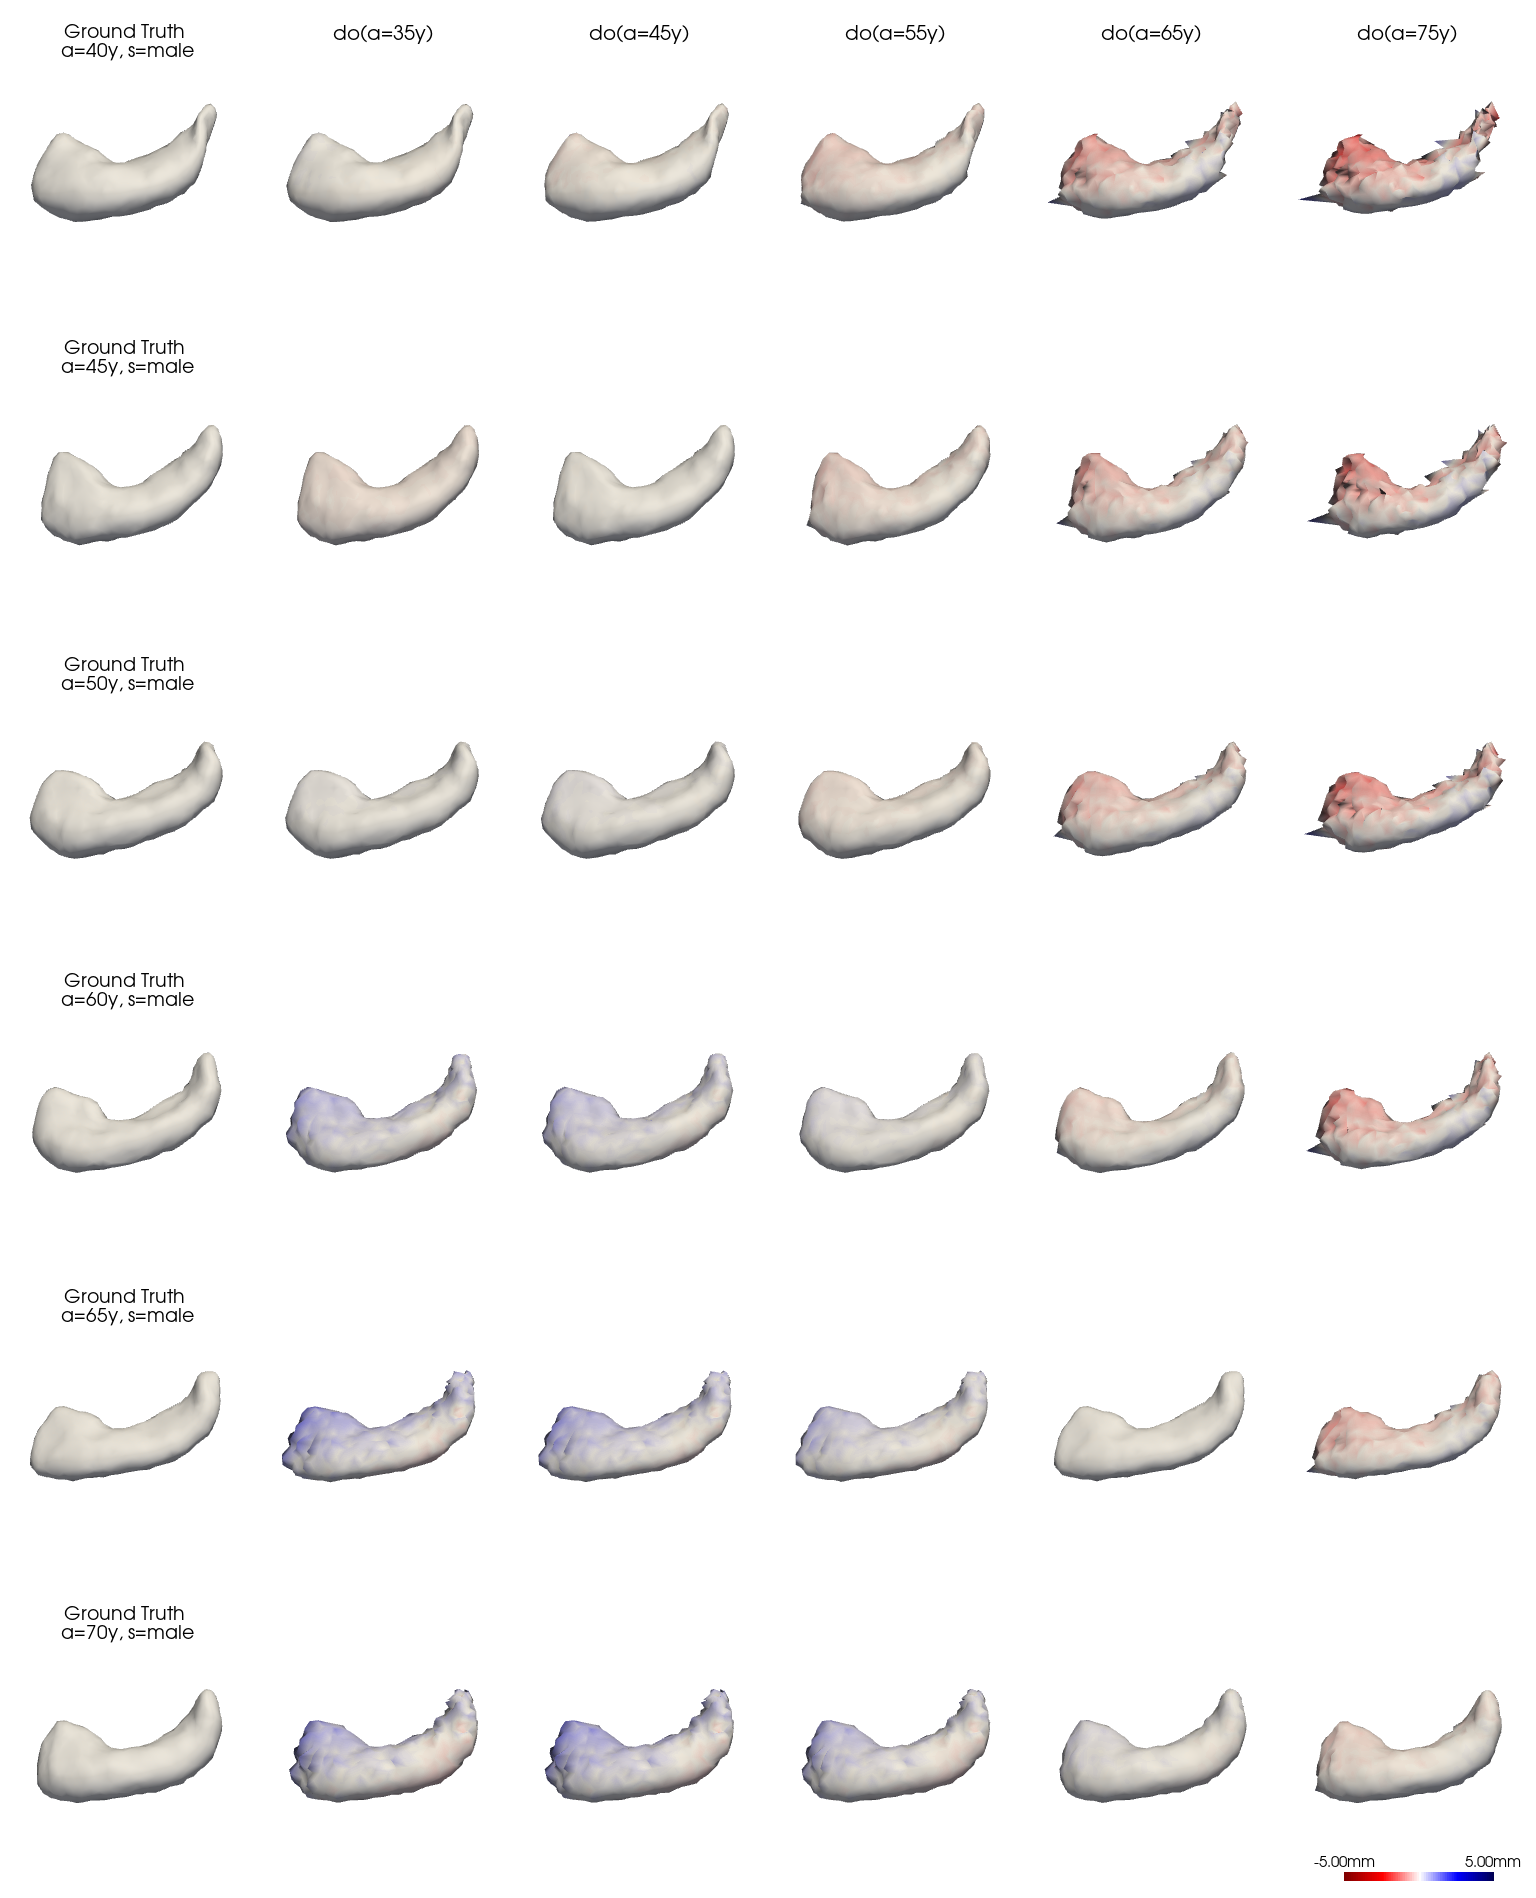

[(110.32332520248973, -50.667056992029316, 152.178234145666),
 (42.105360984802246, -118.8850212097168, 83.96026992797852),
 (0.0, 0.0, 1.0)]

In [83]:
# cfs = np.load('cfs_all_brain_stem_2.npy', allow_pickle=True)[()]

model_idx = 118

width = 768 * 2
height = int(width / 1.618) * 2

plotter = pv.Plotter(
    shape=(6, len(all_age_interventions_list) + 1),
    window_size=(width, height),
    border=False,
    lighting='light_kit',
    off_screen=True,
    notebook=True,
)

for row, _age_sex_pair in enumerate([(40, 1), (45, 1), (50, 1), (60, 1), (65, 1), (70, 1)]):
    sex = _age_sex_pair[1]
    age = _age_sex_pair[0]
    plot_all_age_counterfactuals(
        plotter,
        row,
        cfs[model_idx][_age_sex_pair],
        hipp_template,
        test_hipp_metadata_df,
        test_hipp_meshes,
        age,
        sex,
        all_age_interventions_list,
        rot=(0, 0, 230),
        _clim=[-5., 5.],
    )
    
for i in range(len(all_age_interventions_list)):
    plotter.subplot(0, i + 1)
    do_age_title = f'do({var_name["age"]}={value_fmt["age"](str(int(all_age_interventions_list[i])))})' 
    actor = plotter.add_title(do_age_title, font_size=8)

plotter.subplot(len(_age_sex_pairs) - 1, len(all_age_interventions_list))
plotter.add_scalar_bar(
    label_font_size=15,
    position_x=0.85,
    position_y=0.05,
    title_font_size=20,
    shadow=True,
    n_labels=2,
    fmt='%.2fmm',
    fill=True,
)
    
plotter.show(screenshot='./HIPP_counterfactual_all_ages_m.png')